In [1]:
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import random
import matplotlib.pyplot as plt

### Przygotowanie zbioru danych

In [2]:
image_size = 200  # docelowy rozmiar zdjęcia

In [6]:
# zmiana rozmiaru zdjęć oraz zapisanie ich w innym folderze

n = 0
for photo in os.listdir('photos'):
    image = cv2.imread('photos/{}'.format(photo))
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(image, image_size)
    cv2.imwrite("prepared_photos/photo{}.jpg".format(n), resized)
    n += 1

##### Rozszerzanie zbioru danych - Albumentations

In [11]:
import albumentations as A

In [22]:
# czytanie z pliku xml współrzędnych bboxa

from bs4 import BeautifulSoup

def read_xml_annotations(file_num):
    with open('prepared_photos/photo{}.xml'.format(file_num), 'r') as f:
        data = f.read()
 
    Bs_data = BeautifulSoup(data, "xml")  # czyt

    name = Bs_data.find_all('name')[0].text

    x_min = int(float(Bs_data.find_all('xmin')[0].text))
    y_min = int(float(Bs_data.find_all('ymin')[0].text))
    x_max = int(float(Bs_data.find_all('xmax')[0].text))
    y_max = int(float(Bs_data.find_all('ymax')[0].text))
    
    bbox = [x_min, y_min, x_max, y_max, name]
 
    return bbox, name

In [6]:
def transform_image(image, bbox):
    transformed = transform(image=image, bboxes=[bbox])
    transformed_image = transformed['image']
    transformed_bbox = transformed['bboxes']

    return transformed, transformed_image, transformed_bbox

In [7]:
# zapisywanie zmodyfikowanego obrazu
# zmiana rozmiaru obrazu do wymiarów 200x200

from PIL import Image

def save_t_image(n, transformed_image):
    cto = len(image)/len(transformed_image)  # crop to original - stosunek

    im = Image.fromarray(transformed_image).resize((image_size, image_size))
    im.save('prepared_photos/photo{}.jpg'.format(n))

In [8]:
# zapisywanie w pliku xml etykiet bboxów z nowego obrazka

import xml.etree.cElementTree as ET


def save_annotations_xml(n, bbox, transformed_image, object_name):
    name = 'photo{}.jpg'.format(n)

    cto = len(image)/len(transformed_image)  # crop to original - stosunek

    box = list(bbox[0])
    for i in range(4):
        box[i] = cto * box[i]

    annotation = ET.Element("annotation")
    ET.SubElement(annotation, "folder").text = 'Frames'
    ET.SubElement(annotation, "filename").text = name
    ET.SubElement(annotation, "path").text = 'C:\\Users\\PC\\Politechnika Wrocławska\\Inżynieria systemów\\Semestr 5\\Przetwarzanie obrazów i widzenie komputerowe\\Laboratorium\\koci_projekt\\prepared_photos\\{}'.format(name)
    source = ET.SubElement(annotation, "source")
    ET.SubElement(source, 'database').text = 'Unknown'
    size = ET.SubElement(annotation, 'size')
    ET.SubElement(size, 'width').text = str(image_size)
    ET.SubElement(size, 'height').text = str(image_size)
    ET.SubElement(size, 'depth').text = '3'
    ET.SubElement(annotation, 'segmented').text = '0'

    object = ET.SubElement(annotation, 'object')
    ET.SubElement(object, 'name').text = object_name
    ET.SubElement(object, 'pose').text = 'Unspecified'
    ET.SubElement(object, 'truncated').text = '0'
    ET.SubElement(object, 'difficult').text = '0'
    bndbox = ET.SubElement(object, 'bndbox')
    ET.SubElement(bndbox, 'xmin').text = str(box[0])
    ET.SubElement(bndbox, 'ymin').text = str(box[1])
    ET.SubElement(bndbox, 'xmax').text = str(box[2])
    ET.SubElement(bndbox, 'ymax').text = str(box[3])

    tree = ET.ElementTree(annotation)
    tree.write("prepared_photos/photo{}.xml".format(n))

In [136]:
num_of_copies = 10  # ilość kopii każdego obrazka

for f in os.listdir('prepared_photos'):  # modyfikacje dla każdego zdjęcia
    n = int(f[5:-4])  # numer zdjęcia
    for mod in range(num_of_copies):
        random_size = np.random.randint(120, image_size)  # pomyśl o innych rozmiarach
        transform = A.Compose([
            A.RandomCrop(width=random_size, height=random_size, p=0.7),
            A.RandomBrightnessContrast(p=0.7),  # zmiana jasności
            A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=30, val_shift_limit=10, always_apply=False, p=0.7),  # zmiana nasycenia barw
            A.PixelDropout(dropout_prob=0.01, per_channel=False, drop_value=0, mask_drop_value=None, always_apply=False, p=0.5),  # gubienie pikseli
            A.Flip(p=0.5),
            A.Perspective(scale=(0.05, 0.1), keep_size=True, pad_mode=0, pad_val=0, mask_pad_val=0, fit_output=False, interpolation=1, always_apply=False, p=0.7),
            A.RandomRotate90(p=0.5)
        ], bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.8))  # format bboxów, min. widoczność obiektu, żeby zachować

        image = cv2.imread('prepared_photos/photo{}.jpg'.format(n))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        try:
            bboxes, object_name = read_xml_annotations(n)

            transformed, transformed_image, transformed_bboxes = transform_image(image, bboxes)
            
            save_annotations_xml(num_of_copies*n+38+mod, transformed_bboxes, transformed_image, object_name)
            save_t_image(num_of_copies*n+38+mod, transformed_image)
            
        except IndexError:  # w save_annotations_xml wyskoczy błąd, jeżeli po modyfikacji nie będzie bboxa - takiego zdjęcia nie zapisuje
            continue


Zastosowane modyfikacje:
- RandomCrop - losowe przycięcie obrazu do rozmiarów między 120x120 a 200x200 (oryginalny rozmiar)
- RandomBrightnessContrast - zmiana jasności obrazu
- HueSaturationLevel - zmiana nasycenia barw
- PixelDropout - "gubienie" pikseli - losowa zamiana pikseli na kolor czarny z prawdopodobieństwem 0.01
- Flip - obrót obrazu
- Perspective - sztuczna zmiana perspektywy poprzez rozciągnięcie obrazu
- RandomRotate90 - obrót obrazu o 90 stopni w dowolną stronę

In [11]:
print('ilość zdjęć po rozszerzaniu: {}'.format(int(len(os.listdir('prepared_photos'))/2)))

ilość zdjęć po rozszerzaniu: 358


##### Zapisanie, wymieszanie i podzielenie na zbiór treningowy oraz testowy

In [90]:
# zrobienie df ze wszystkimi bboxami i zapisanie ich w pliku csv

X = []
Y = []

column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    
for file in os.listdir('prepared_photos'):
    if file[-3:] == 'jpg':
        image = cv2.imread('prepared_photos/{}'.format(file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype("float") / 255.0  # normalizacja
        X.append(image)

    if file[-3:] == 'xml':
        bbox, name = read_xml_annotations(file[5:-4])
        
        Y.append([file[:len(file)-4]+'.jpg', image_size, image_size, name, bbox[0], bbox[1], bbox[2], bbox[3]])

Y_df = pd.DataFrame(Y, columns=column_name)
Y_df.to_csv(('Y.csv'), index=None)

In [91]:
# wyciągnięcie z df labeli i bboxów do osobnych np.array
# normalizacja bboxów

Y_names = []
Y_boxes = []

w, h, = Y_df['width'], Y_df['height']

for x1, y1, x2, y2 in zip(list(Y_df['xmin']/w), list(Y_df['ymin']/h),list(Y_df['xmax']/w), list(Y_df['ymax']/h)): 
    arr = [x1, y1, x2, y2]
    Y_boxes.append(arr)

Y_boxes = np.array(Y_boxes)
Y_names = np.array(Y_df["class"])

In [92]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# one-hot
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(Y_names)
onehot_labels = to_categorical(integer_labels)
 
# pomieszanie danych
combined_list = list(zip(X, Y_boxes, onehot_labels))
random.shuffle(combined_list)
img_list, boxes, onehot_labels = zip(*combined_list)

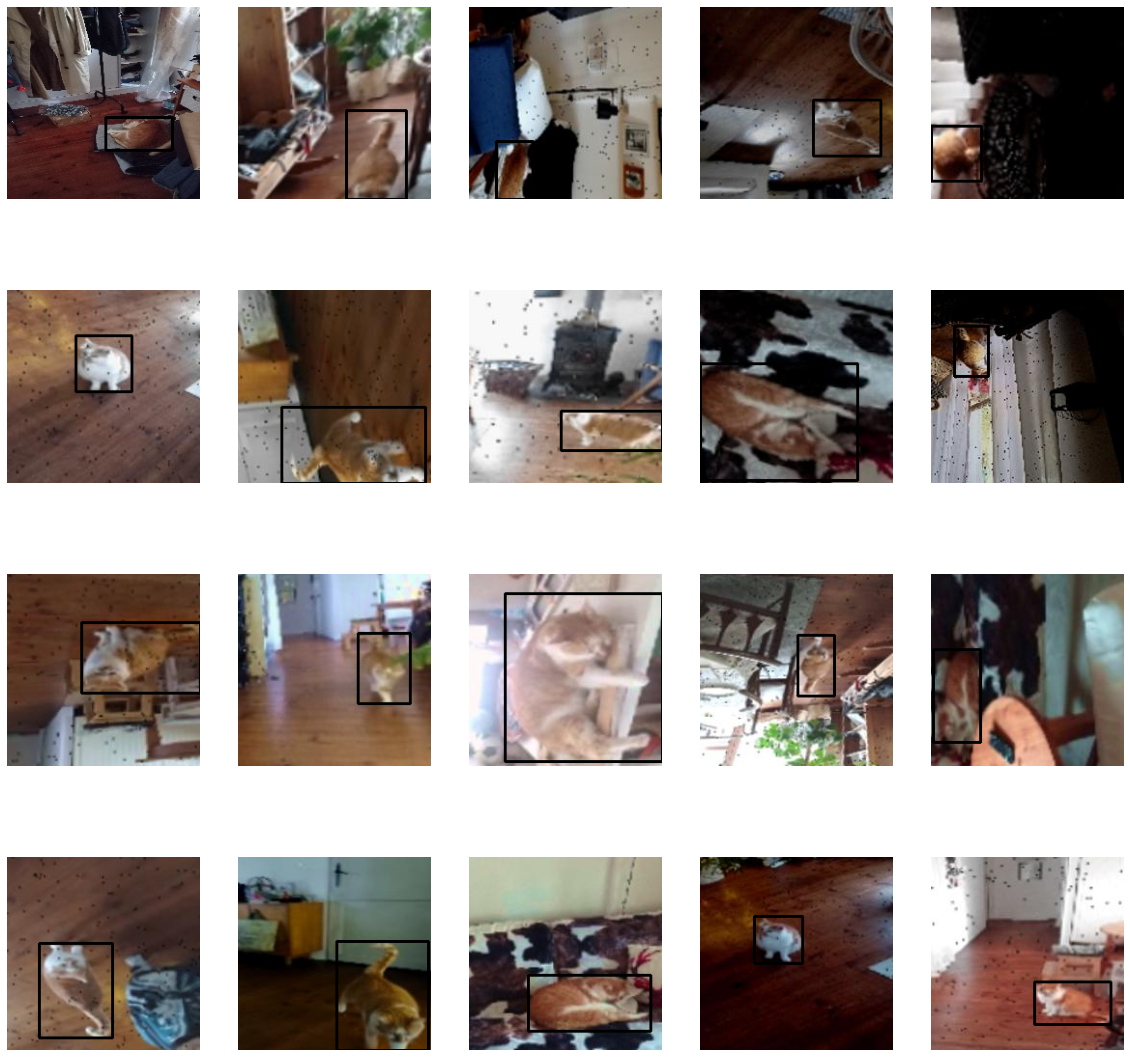

In [93]:
# wyświetlenie przykładowych obrazków

plt.figure(figsize=(20,20));
 
random_range = random.sample(range(1, len(img_list)), 20)

for i in range(len(random_range)):
      a1, b1, a2, b2 = boxes[random_range[i]];

      x1 = a1 * image_size
      x2 = a2 * image_size
      y1 = b1 * image_size
      y2 = b2 * image_size

      image = img_list[random_range[i]]
      
      cv2.rectangle(image, (int(x1),int(y1)),
            (int(x2),int(y2)), (0,255,0), 2);
      
      plt.subplot(4, 5, i+1);
      plt.imshow((image*255).astype(np.uint8));
      plt.axis('off');

In [94]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels, train_boxes, test_boxes = train_test_split(np.array(img_list), 
                np.array(onehot_labels), np.array(boxes), test_size=0.15)
 
print('Rozmiar zbioru treningowego: {}, Rozmiar zbioru testowego: {}'.format(len(train_images), len(test_images)))

Rozmiar zbioru treningowego: 304, Rozmiar zbioru testowego: 54


In [95]:
# zapisanie podzielonych zbiorów

with open('train_images.txt', 'w') as f:
    for slice_3d in train_images:
        for slice_2d in slice_3d:
            np.savetxt(f, slice_2d)
f.close()

with open('test_images.txt', 'w') as f:
    for slice_3d in test_images:
        for slice_2d in slice_3d:
            np.savetxt(f, slice_2d)
f.close()

with open('train_labels.txt', 'w') as f:
    for slice_2d in train_labels:
        np.savetxt(f, slice_2d)
f.close()

with open('test_labels.txt', 'w') as f:
    for slice_2d in test_labels:
        np.savetxt(f, slice_2d)
f.close()

with open('train_boxes.txt', 'w') as f:
    for slice_2d in train_boxes:
        np.savetxt(f, slice_2d)
f.close()

with open('test_boxes.txt', 'w') as f:
    for slice_2d in test_boxes:
        np.savetxt(f, slice_2d)
f.close()

In [3]:
train_images = np.loadtxt('train_images.txt').reshape((304, 200, 200, 3))
test_images = np.loadtxt('test_images.txt').reshape(54, 200, 200, 3)

train_labels = np.loadtxt('train_labels.txt').reshape(304, 2)
test_labels = np.loadtxt('test_labels.txt').reshape(54, 2)

train_boxes = np.loadtxt('train_boxes.txt').reshape((304, 4))
test_boxes = np.loadtxt('test_boxes.txt').reshape((54, 4))

### Modele

In [4]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Flatten, Dense, Concatenate, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.utils import plot_model

##### Gotowiec - NASNet

In [5]:
# NasNetMobile Model
N_mobile = tf.keras.applications.NASNetMobile(input_tensor=Input(
    shape=(image_size, image_size, 3)), 
    include_top=False, 
    weights='imagenet'
    )

In [8]:
N_mobile.trainable = False
 
we_got = N_mobile.output
we = Input(shape=(image_size, image_size, 3), name='wejscie')

flat = Flatten()(we_got)


class_pred = Dense(256, activation='relu')(flat)
class_pred = Dense(128, activation='relu')(class_pred)
class_pred = Dropout(0.2)(class_pred)
class_pred = Dense(64, activation='relu')(class_pred)
class_pred = Dense(32, activation='relu')(class_pred)
class_pred = Dense(2, activation='softmax', name='class_output')(class_pred)

box = Dense(256, activation='relu')(flat)
box = Dense(128, activation='relu')(box)
box = Dropout(0.2)(box)
box = Dense(64, activation='relu')(box)
box = Dense(32, activation='relu')(box)
box = Dense(4, activation='sigmoid', name= 'box_output')(box)

nn_got = Model(inputs=N_mobile.input, outputs= [box, class_pred])

In [7]:
plot_model(nn_got, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [98]:
losses = { 
    'box_output': "mean_squared_error",
    'class_output': "categorical_crossentropy"
    }
 

loss_weights = {
    'box_output': 5.0, 
    'class_output': 1.0
    }
 

metrics = {
    'box_output':  'mean_squared_error',
    'class_output': 'accuracy'
    }

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
 

callback_checkpoint = tf.keras.callbacks.ModelCheckpoint('nn_got.h5', monitor='val_loss', mode='min',
	save_best_only=True, verbose=1)


 
nn_got.compile(optimizer='adam', loss=losses, loss_weights=loss_weights, metrics=metrics)

In [99]:
history = nn_got.fit(x = train_images, 
                    y= {'box_output': train_boxes, 
                        'class_output': train_labels}, 
                    validation_data=(
                        test_images, 
                        {'box_output': test_boxes, 
                          'class_output': test_labels}), batch_size=16, epochs=500, 
                    callbacks=[stop, callback_checkpoint]
                        )

Epoch 1/500
19/19 [==============================] - ETA: 0s - loss: 2.8379 - box_output_loss: 0.1593 - class_output_loss: 2.0415 - box_output_mean_squared_error: 0.1593 - class_output_accuracy: 0.6414
Epoch 1: val_loss improved from inf to 1.03486, saving model to nn_got.h5
19/19 [==============================] - 58s 1s/step - loss: 2.8379 - box_output_loss: 0.1593 - class_output_loss: 2.0415 - box_output_mean_squared_error: 0.1593 - class_output_accuracy: 0.6414 - val_loss: 1.0349 - val_box_output_loss: 0.1262 - val_class_output_loss: 0.4037 - val_box_output_mean_squared_error: 0.1262 - val_class_output_accuracy: 0.8889
Epoch 2/500
19/19 [==============================] - ETA: 0s - loss: 1.6505 - box_output_loss: 0.1603 - class_output_loss: 0.8489 - box_output_mean_squared_error: 0.1603 - class_output_accuracy: 0.8421
Epoch 2: val_loss did not improve from 1.03486
19/19 [==============================] - 18s 971ms/step - loss: 1.6505 - box_output_loss: 0.1603 - class_output_loss: 0.

In [7]:
from tensorflow.keras.models import load_model

model_got = load_model('nn_got.h5')

In [4]:
labels = ['asleep', 'awake']

In [5]:
t = []
for l in test_labels:
    t.append(list(l).index(1))

2/2 [==============================] - 4s 1s/step


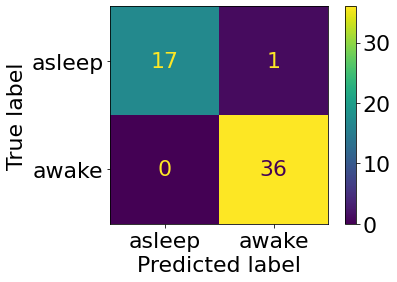

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Y_pred = np.argmax(model_got.predict(test_images)[1], axis=1)
#test_labels = np.argmax(test_labels, axis=1)

cm = confusion_matrix(t, Y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.rcParams.update({'font.size': 22})

disp.plot();

In [27]:
box_pred = model_got.predict(test_images)[0]
se = 0
for box in range(len(box_pred)):
    for pos in range(4):
        se += (box_pred[box][pos] - test_boxes[box][pos])**2
mse = se/len(box_pred)
mse

2/2 [==============================] - 3s 1s/step


0.13442680731446088

In [15]:
def predict(img, model, labels):
    image = cv2.resize(img, (image_size, image_size))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype("float") / 255.0
    image = np.expand_dims(image, axis=0)

    results = model.predict(image)
    
    bounding_box, class_probs = results

    class_index = np.argmax(class_probs)
    class_label = labels[class_index]

    h, w = img.shape[:2]
    x1, y1, x2, y2 = bounding_box[0]

    x1 = int(x1 * w)
    x2 = int(x2 * w)
    y1 = int(y1 * h)
    y2 = int(y2 * h)

    print(class_label, (x1, y1, x2, y2), class_probs)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 8)

    plt.figure(figsize=(10,10))
    plt.title(class_label)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')

1/1 [==============================] - 0s 77ms/step
awake (739, 1770, 1687, 2399) [[0.00122463 0.9987753 ]]


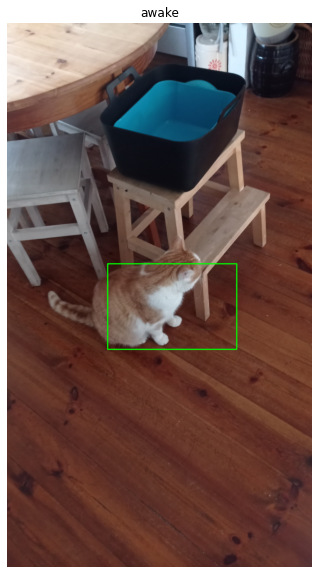

In [10]:
image = cv2.imread('IMG_20230107_134337.jpg' )
#image = cv2.imread('IMG_20230107_093756.jpg' )
#image = cv2.imread('IMG_20230106_130923.jpg' )
#image = cv2.imread('photos/IMG_20220823_101917.jpg')

predict(image, model_got, labels)

##### Własny model

In [ ]:
we = Input(shape=(image_size, image_size, 3), name='wejscie')

conv1 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', input_shape=(image_size, image_size, 3))(we)
pool1 = MaxPool2D(pool_size=(2,2))(conv1)
conv2 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(pool1)
pool2 = MaxPool2D(pool_size=(2,2))(conv2)

flat = Flatten()(pool2)

class_pred = Dense(256, activation='relu')(flat)
class_pred = Dense(128, activation='relu')(class_pred)
class_pred = Dropout(0.2)(class_pred)
class_pred = Dense(64, activation='relu')(class_pred)
class_pred = Dense(32, activation='relu')(class_pred)
class_pred = Dense(2, activation='softmax', name='class_output')(class_pred)

box = Dense(256, activation='relu')(flat)
box = Dense(128, activation='relu')(box)
box = Dropout(0.2)(box)
box = Dense(64, activation='relu')(box)
box = Dense(32, activation='relu')(box)
box = Dense(4, activation='sigmoid', name='box_output')(box)

nn = Model(inputs=we, outputs= [box, class_pred])

In [8]:
losses = { 
    'box_output': "mean_squared_error",
    'class_output': "categorical_crossentropy"
    }
 

loss_weights = {
    'box_output': 5.0, 
    'class_output': 1.0
    }
 

metrics = {
    'box_output':  'mean_squared_error',
    'class_output': 'accuracy'
    }

stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
 

callback_checkpoint = tf.keras.callbacks.ModelCheckpoint('nn_own.h5', monitor='val_loss', mode='min',
	save_best_only=True, verbose=1)


 
nn.compile(optimizer='adam', loss=losses, loss_weights=loss_weights, metrics=metrics)

In [9]:
history = nn.fit(x=train_images, 
                    y= {'box_output': train_boxes, 
                        'class_output': train_labels}, 
                    validation_data=(
                        test_images, 
                        {'box_output': test_boxes, 
                          'class_output': test_labels}), batch_size=16, epochs=500, 
                    callbacks=[stop, callback_checkpoint]
                        )

Epoch 1/500
19/19 [==============================] - ETA: 0s - loss: 2.3828 - box_output_loss: 0.1685 - class_output_loss: 1.5400 - box_output_mean_squared_error: 0.1685 - class_output_accuracy: 0.4868
Epoch 1: val_loss improved from inf to 2.60693, saving model to nn_own.h5
19/19 [==============================] - 16s 655ms/step - loss: 2.3828 - box_output_loss: 0.1685 - class_output_loss: 1.5400 - box_output_mean_squared_error: 0.1685 - class_output_accuracy: 0.4868 - val_loss: 2.6069 - val_box_output_loss: 0.0881 - val_class_output_loss: 2.1666 - val_box_output_mean_squared_error: 0.0881 - val_class_output_accuracy: 0.6667
Epoch 2/500
19/19 [==============================] - ETA: 0s - loss: 1.1136 - box_output_loss: 0.0844 - class_output_loss: 0.6914 - box_output_mean_squared_error: 0.0844 - class_output_accuracy: 0.6513
Epoch 2: val_loss improved from 2.60693 to 2.52310, saving model to nn_own.h5
19/19 [==============================] - 12s 635ms/step - loss: 1.1136 - box_output_lo

In [13]:
from tensorflow.keras.models import load_model

model_own = load_model('nn_own.h5')

In [11]:
t = []
for l in test_labels:
    t.append(list(l).index(1))

2/2 [==============================] - 1s 281ms/step


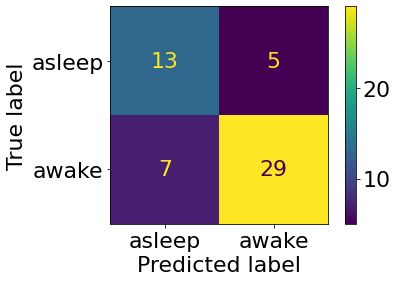

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Y_pred = np.argmax(model_own.predict(test_images)[1], axis=1)

cm = confusion_matrix(t, Y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.rcParams.update({'font.size': 22})

disp.plot();

In [29]:
box_pred = model_own.predict(test_images)[0]
se = 0
for box in range(len(box_pred)):
    for pos in range(4):
        se += (test_boxes[box][pos] - box_pred[box][pos])**2
mse = se/len(box_pred)
mse

2/2 [==============================] - 0s 155ms/step


0.23354343308720296

1/1 [==============================] - 0s 51ms/step
awake (989, 1699, 1306, 2716) [[0.13075419 0.8692458 ]]


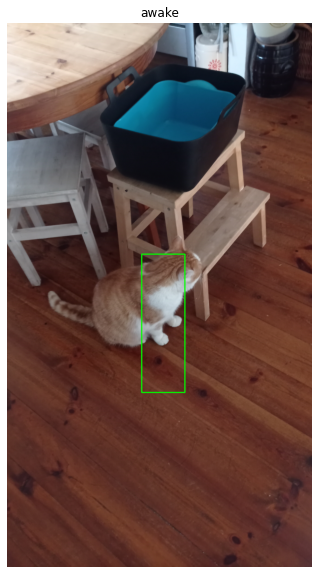

In [24]:
image = cv2.imread('IMG_20230107_134337.jpg' )
#image = cv2.imread('IMG_20230107_093756.jpg' )
#image = cv2.imread('IMG_20230106_130923.jpg' )
#image = cv2.imread('photos/IMG_20220823_101917.jpg')

predict(image, model_own, labels)

In [10]:
prob = 0
for i in test_labels:
    prob += np.argmax(i)
prob /= len(test_images)
prob

0.6666666666666666

##### Pseudo-klasyfikator

In [11]:
monke = []
for _ in range(54):
    r = random.random()
    if r < prob:
        monke.append(1)
    else:
        monke.append(0)

In [ ]:
cm = confusion_matrix(t, monke, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.rcParams.update({'font.size': 22})
disp.plot();